<a href="https://colab.research.google.com/github/junzeye/stats305b_LLM/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4: Large Language Models

The first half of this assignment (Parts 0 and 1) will review some key ingredients of sequence modeling. In the process, we will build a baseline transformer model for next token prediction in code.
**The deliverable will be completing the questions posed in part 0 and part 1.**

The second half of the assignment (Part 2) will be an open-ended mini-project where you have the freedom to delve more deeply into language modelling (where the language in question is python code). Further instructions are in _Part 2: Mini-project_. But, in general, you should feel free to try other architectures (HMMs, RNNs, transformers, state space layers, diffusion models etc.) or to invent new architectures. The goal will be to find some area of possible improvement (we interpret "improvement" quite loosely, but it is up to you to state precisely in what sense your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not constitue an improvement according to your definition); to formulate and state a precise hypothesis; and to falsify or support the hypothesis with rigorous empirical analyses.
**The deliverable will be a report of no more than 4 pages (references not included in the page limit).**

**For this final assignment you have the option to work in pairs.**


> **<u>This Assignment</u>**
>
>**Model:** You will begin by implementing a baseline using attention and transformers. But, for the mini-project, you will be free to use any model (HMMs, RNNs, transformers, state space layers, diffusion models etc.) that you would like!
>
>**Algorithm:** mini-batched stochatic gradient descent / whatever you'd like! We will be using deep learning models in at least the first half of the assignment, so be sure to **use the GPU on colab** (make sure you switch to GPU in the "Runtime" tab above).
>
>**Data**: A large corpus of python code from [the Stack](https://huggingface.co/datasets/bigcode/the-stack-dedup). We have taken a dataset of around 4 million tokens from the stack and stored in a csv file for you for easy access.

## Setup

In [1]:
# can take around 30s
%%capture
! pip install datasets #huggingface datasets library
! pip install --upgrade pyarrow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# hugging face imports
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import sys
import warnings

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# assert device=='cuda', "you need to change runtime type to GPU"

In [4]:
# hyperparams and helper functions
SMALL_ITERS = 1000
LARGE_ITERS = 2000
context_window_size = 256
chunk_size = 512 # BERT can only take max input size 512 characters

def chunk_string(string, size):
    """
    Splits a string into chunks of a specified size.

    :param string: The string to be chunked.
    :param size: The desired chunk size.
    :return: A list of string chunks.
    """
    return [string[i:i+size] for i in range(0, len(string), size)]

## Part 0: Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading the dataset

The first step is to actually download the dataset. We will be using a dataset on [huggingface](https://huggingface.co/). You can think of hugging face as the sklearn of deep learning.

The dominant mode for preprocessing textual data is to tokenize it, that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionary where counting numbers map to tokens. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research. For our baseline, we will use a tokenizer that microsoft created for code.

In [5]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/CodeBERT-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
# Load the concatenated data
raw_data = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw4/python_corpus_4M.csv", header=None)

In [7]:
# should take around 3 min to load in around 4M tokens
warnings.filterwarnings("ignore")

tokens = torch.tensor([], dtype=torch.long)
for index, row in raw_data.iterrows():
    text = row[0]
    chunks = chunk_string(text, chunk_size)
    n = len(chunks)
    for idx, chunk in enumerate(chunks):
        new_tokens = torch.tensor(tokenizer.encode(chunk, add_special_tokens=True))

        # logic to avoid incorrectly adding in start and end sequence tokens as an artifact of chunking
        if idx == 0:
            tokens = torch.cat((tokens, new_tokens[:-1]), dim=0)
        elif idx == n-1:
            tokens = torch.cat((tokens, new_tokens[1:]), dim=0)
        else:
            tokens = torch.cat((tokens, new_tokens[1:-1]), dim=0)

print(f"{len(tokens)} tokens have been loaded in")

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


4000596 tokens have been loaded in


### Question 0.2: Examining the tokenizer

Let's see what the tokens look like! We will use these two prompts during the assignment.

In [8]:
prompt_1_text = \
"""def newton(eta, N, X, y, gamma, beta=None):
  \"""
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  \"""

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):"""

In [9]:
prompt_2_text = \
"""import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    \"""Performs L2-Norm.\"""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    \"""Computes Euclidean distance.\"""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):"""

Here is what the tokenized output for the prompts looks like

In [10]:
tokenizer.decode(tokenizer.encode(prompt_1_text))

'<s>def newton(eta, N, X, y, gamma, beta=None):\n  """\n  Performs Newton\'s method on the negative average log likelihood with an\n  l2 regularization term\n\n  beta: torch.Tensor, of shape (teams)\n  X: torch.Tensor, the covariate matrix, of shape (-1, teams)\n  y: torch.Tensor, the response vector, of shape (teams)\n  gamma: float, the scale parameter for the regularization\n  beta: torch.Tensor, the starting point for gradient descent, if specified\n  """\n\n  if beta is None:\n    # Instantiate the beta vector at a random point\n    beta = torch.randn(X.shape[1])\n  else:\n    beta = torch.clone(beta)\n\n  loss = []\n\n  # Instantiate a list to store the loss throughout the gradient descent\n  # path\n  for i in tqdm(range(N)):</s>'

In [11]:
tokenizer.decode(tokenizer.encode(prompt_2_text))

'<s>import torch\nimport torch.nn.functional as F\n\n\ndef normalize(x, axis=-1):\n    """Performs L2-Norm."""\n    num = x\n    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12\n    return num / denom\n\ndef euclidean_dist(x, y):\n    """Computes Euclidean distance."""\n    m, n = x.size(0), y.size(0)\n    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)\n    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()\n    dist = xx + yy - 2 * torch.matmul(x, y.t())\n\n    dist = dist.clamp(min=1e-12).sqrt()\n\n    return dist\n\n\ndef cosine_dist(x, y):</s>'

And here are what the first and last 10 tokens for prompt 1 look like:

In [12]:
for tok in tokenizer.encode(prompt_1_text, add_special_tokens=True)[:10]:
    print(f"{tok} : {tokenizer.decode([tok])}")

0 : <s>
9232 : def
92 :  new
1054 : ton
1640 : (
8152 : eta
6 : ,
234 :  N
6 : ,
1577 :  X


In [13]:
for tok in tokenizer.encode(prompt_1_text)[-10:]:
    print(f"{tok} : {tokenizer.decode([tok])}")

326 :  t
1343 : q
43604 : dm
1640 : (
9435 : range
1640 : (
487 : N
43 : )
3256 : ):
2 : </s>


**Question 0.2**: What is the meanining of the `<s>` and the `<\s>` tokens? Why is it useful to have them?

**Answer:** The \<s> and \</s> tokens are special markers used in the context of language model training and processing to indicate the beginning and end of a sentence or text sequence, respectively. This is crucial for models to understand where a sentence or a coherent piece of text begins and ends, especially when processing multiple sentences or paragraphs in a single input. In addition, these tokens can signal different stages of processing or be used to trigger specific behaviors. For instance, in sequence-to-sequence models, the \<s> token might signal the start of a generation task, while \</s> indicates that the model should stop generating further text.

### 0.3: Building our dataloader

There are around 50,000 tokens in the codebert vocab, but we only use around 20,000 of them. To make our lives easier, we just reindex the token indices to go from 1 to around 20,000.

In [14]:
# Get unique elements
extra_tokens = torch.cat((torch.tensor(tokenizer.encode(prompt_1_text, add_special_tokens=True)),
                          torch.tensor(tokenizer.encode(prompt_2_text, add_special_tokens=True))),
                         dim=0)

unique_tokens = torch.unique(torch.cat((tokens, extra_tokens), dim=0))

# Create a mapping from code bert to ids that increment by one
from_code_bert_dict = {element.item(): id for id, element in enumerate(unique_tokens)}

# Create a reverse mapping from ids to code bert token ids
to_code_bert_dict = {id: element for element, id in from_code_bert_dict.items()}

vocab_size = len(unique_tokens)
print(f"there are {vocab_size} distinct tokens in the vocabulary")

# helper functions to move between code bert and simple ids
def from_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of code bert tokens
    Returns:
    a list of simple ids
    """
    tkns = [int(from_code_bert_dict[token]) for token in tkn_lst]
    return tkns


def to_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of simple ids (can also be of type torch.Tensor)
    Returns:
    a list of code bert tokens
    """
    if isinstance(tkn_lst, torch.Tensor):
        tkn_lst = tkn_lst.cpu().numpy()
    tkns = [int(to_code_bert_dict[token]) for token in tkn_lst]
    return tkns

there are 21970 distinct tokens in the vocabulary


In [15]:
# let's translate our dataset into our ids
tokens_simple_id = torch.tensor([from_code_bert_dict[token.item()] for token in tokens])

# split up the data into train and validation sets
n = int(0.9 * len(tokens_simple_id)) # first 90% will be train, rest val
train_data = tokens_simple_id.clone()[:n]
val_data = tokens_simple_id.clone()[n:]

print(f"there are {len(train_data)} tokens in the training set")
print(f"there are {len(val_data)} tokens in the validation set")
print(f"there are {vocab_size} distinct tokens in the vocabulary")

there are 3600536 tokens in the training set
there are 400060 tokens in the validation set
there are 21970 distinct tokens in the vocabulary


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [16]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [17]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])


## Part 1: Language Modeling

In this first part of the assignment, we will implement a baseline for code modeling.

In the process of building this baseline, we will review 4 key ideas of sequence modeling that have become the backbone of modern language modeling such as ChatGPT:

1. Framing language modeling as next token prediction, and next token prediction as multiclass logistic regression
2. Embedding discrete tokens in continuous latent spaces (word embeddings)
3. Use the attention mechanism to move beyond Markovian models for sequences (we of course pay for this greater expressivity with increased compute, which is made possible in part by using matrix multiplications on acccelerated hardware like GPUs. Reducing the compute burden while maintaining the expressivity needed for good sequence modeling is an active area of research).
4. Combining attention with deep learning in the Transformer architecture.

### 1.1: Next token prediction as multiclass logistic regression

Our first language model will simply be a lookup table. That is, given that we have token with value $v$, we will simply "look up" the logits that correspond to our prediction for the next token. This model is often known as a "bigram model" because it can be derived from the relative proportions of different bigrams (ordered pairs of tokens) occurring in a large text corpus.

Let us be a bit more precise in our definition of the bigram model. Let's say that the total size of our vocabulary (the number of tokens we are using) is $V$. Let $A$ be a matrix in $\mathbb{R}^{V \times V}$, where each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$.
Thus, we are modeling the distribution of the token following a token that has value $v$ as
\begin{align*}
y_{t+1} \mid y_t &= v \sim \mathrm{Cat}(\mathbf{\pi}) \\
\pi &=\mathrm{softmax}(A_v)
\end{align*}

#### Question 1.1.1

$\mathbf{\pi} \in \Delta_{V-1}$ is the vector of probabilities used to parameterize the categorical distribution for the next token prediction. Explain why we parameterize
\begin{equation*}
  \mathbf{\pi} = \mathrm{softmax}(A_v),
\end{equation*}
and could not just use
\begin{equation*}
  \mathbf{\pi} = A_v.
\end{equation*}

---

**Answer:** Raw logits are unnormalized values, meaning that the sum of each row $A_v$ will likely be unequal to $1$. Because $\pi$ lives in a probability simplex, we need to apply a normalizer like the softmax function to make sure that the entries of each row $A_v$ are non-negative and sum up to $1$.

---

#### Question 1.1.2

Discuss the relationship between the bigram model and contigency tables (discussed in Lecture 2).

---

**Answer:** In the context of language modeling, we can interpret contingency tables as a tool for estimating the distribution of different bigrams from a text corpus. The row indices of a contingency model are the first word of a bigram whereas the column indices are the second word of a bigram. The matrix entries are the counts of the corresponding bigram in the training data. Linking back to the above discussion, we can use the contingency obtained this way as the matrix $A$.

Contingency tables provide a structured way to represent the data that a bigram model needs. By organizing word occurrences into a table, it becomes straightforward to access and visualize the counts needed for probability calculations, facilitating the model's training and usage.

---

#### Question 1.1.3

Say I have a string of three tokens with ids $(7, 3, 6)$. If I use the bigram model as a generative model for language, given this information, what is distribution of the fourth token?

---

**Answer:** Suppose our entire vocabulary is $(7,3,6)$. Then the string of three tokens gives rise to the following contingency table $A$:

|     | 7  | 3  | 6  |
|-----|----|----|----|
| **7** | 0 | 1 | 0  |
| **3** | 0 | 0 | 1  |
| **6** | 0 | 0 | 0  |

If we were to apply the softmax function to each row of the matrix, we see that the distribution of the fourth token is a discrete uniform distribution over the entire vocabulary (i.e., $1/3$ for each token).

---

#### Question 1.1.4

Remember back in Section 0.2 "Tokenizing the data" when we gave you the helper function `get_batch`? Run `get_batch` and look at the inputs `x` and the targets `y`. Explain any relation between them in the context of formulating language modeling in the context of next token prediction.

In [ ]:
xb, yb = get_batch('train', 10, device, batch_size = 1)
print(f"the features have token ids {xb}")
print('\n')
print(f"the targets have token ids {yb}")

the features have token ids tensor([[ 8113,  7989,   125,  3687,   325,  1491,  1975,   105, 21047,  6630]],
       device='cuda:0')


the targets have token ids tensor([[ 7989,   125,  3687,   325,  1491,  1975,   105, 21047,  6630, 19900]],
       device='cuda:0')


**Answer:** `x` represents the first words in bigram pairs, whereas `y` represents the corresponding second words in bigram pairs. The targets vector is a $1$-offset version of the inputs vector, which is what we would expect for a model that performs next token prediction. The formatting of the training data reflects our objective of fitting a model that will predict the most likely next token, given the previous token. The fact that `y` is just an offset version of `x` also illustrates the convenient generation of bigram training data from a text corpus.

#### Question 1.1.5

Discuss the strengths and weaknesses of the bigram model as a generative model for language.

---

Some strengths of the bigram model:
- **Simplicity and Efficiency**: Bigram models are straightforward to implement and understand. They rely on the conditional probability of a word given its immediate predecessor, making them computationally efficient compared to more complex models. This simplicity allows quick training and prediction processes, which is especially useful for applications with limited computational resources.
- **Context Awareness**: Although limited, bigram models incorporate a basic level of context by considering the previous word in generating the next word. This is a step up from unigram models, which treat each word occurrence as independent, and can lead to more coherent text generation than purely random word selection.

Some weaknesses of the bigram model:
- **Limited Context**: A major limitation of bigram models is their consideration of only the immediate previous word for predicting the next word. This severely restricts their ability to capture longer dependencies or the overall context of a sentence. Consequently, bigram models often output grammatically incorrect or nonsensical text.

- **Sparse Data Problem**: Bigram models suffer from the issue of data sparsity. Many possible word pairs may not occur in the training corpus, leading to zero probabilities for these unseen bigrams. This issue necessitates the use of smoothing techniques, which can introduce their own complexities and biases.

---

#### Question 1.1.6

Say I have a string $s$ of length $T$. Derive the formula for the negative log likelihood of $s$ under the bigram model in terms of the matrix of logits $A$. What would your answer be if the matrix of logits $A$ were all zeros? What would be the value of the negative log likelihood of $s$ under a model that always perfectly predicted the next token?

---

**Answer:** Let $\mathbb{V}$ be our tokens set with size $V$. Let $s = x_1 x_2 x_3 \cdots x_T$, where $x_i \in [V]$. $A \in \mathbb{R}^{V \times V}$ is matrix of logits where each row $A_v$ corresponds to the logits for the prediction of the next token after token $v$. Without loss of generality, we assume that $x_1$ always corresponds to the `<s>` token, while $x_T$ always represents the `<\s>` token. The likelihood of observing $s$, conditioned on the logits matrix being $A$, is $P(\{x_t\}_{t=1}^{T} \mid A)$. This can be further expanded into
\begin{align*}
P(\{x_t\}_{t=1}^{T} \mid A) &= \prod_{t=1}^{T-1} P(x_{t+1} \mid x_{t}; A),
\end{align*}
where we omit the prior probability $P(x_1)$ since $x_1$ is fixed. The transition probability is:
\begin{align*}
P(x_{t+1} \mid x_{t}; A) &= \sigma(A_{x_t})_{x_{t+1}}  \\
    &= \frac{\exp(A_{x_t,x_{t+1}})}{\sum_{v=1}^V \exp(A_{x_t, v})}.
\end{align*}

The negative log likelihood of $s$ under the bigram model is the negative log of the above expression, which is evaluated as

\begin{align*}
L   &= - \sum_{t=1}^{T-1} \log P(x_{t+1} \mid x_{t}; A) \\
    &= - \sum_{t=1}^{T-1} \log \frac{\exp(A_{x_t,x_{t+1}})}{\sum_{v=1}^V \exp(A_{x_t, v})} \\
    &= - \sum_{t=1}^{T-1} \log \exp(A_{x_t,x_{t+1}}) + \sum_{t=1}^{T-1} \log [\sum_{v=1}^{V} \exp(A_{x_t, v})] \\
    &= - \sum_{t=1}^{T-1} A_{x_t,x_{t+1}} + \sum_{t=1}^{T-1} \log [\sum_{v=1}^{V} \exp(A_{x_t, v})]
\end{align*}

When $A$ is a zero matrix, the above expression of $L$ evaluates to $- (T-1) \log (\frac{1}{V})$, or approximately $\log V$ per token. If a model always perfectly predicted the next token, the negative log likelihood of $s$ will evaluate to $0$.

---

#### Question 1.1.7: Implement the BigramLanguageModel

Implement the bigram language model below.

Your TODOs:
  * if the `forward` method is provided a target, the loss should be the negative log likelihood of the target (given the context)
  * `generate` should take in (batched) contexts and a number of new tokens to generate, and then generate text from your model.


In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Args:
          vocab_size: size of the vocabulary (the number of tokens)
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.logits_table = nn.Embedding(vocab_size, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: Int(B, T), token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: Int(B, T), token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """

        # idx and targets are both (B,T) tensor of integers
        logits = self.logits_table(token_ids) # (B,T,V)
        log_probits = F.log_softmax(logits, dim = 2) # log of the softmax along the dimension with V elements

        if targets is None:
            loss = None
        else:
            log_condit_probs = torch.gather(log_probits, dim = 2,
                                            index = targets.unsqueeze(2)).squeeze(2)
            loss = - log_condit_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=context_window_size):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        assert (max_new_tokens > 0)
        B, T = token_ids.shape # (batch size, length)

        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64, device = device)
        combined_token_ids = torch.concat((token_ids, new_token_ids), dim = 1) # (B, T + max_new_tokens)

        for t in range(max_new_tokens):
            logits, _ = self.forward(combined_token_ids[:, t:T+t]) # (B, T, V).
            logits = logits[:, -1, :] # (B, V). Focus only on the last time step
            probs = F.softmax(logits, dim = -1)
            next_idx = torch.multinomial(probs, num_samples = 1) # (B, 1)
            combined_token_ids[:, T + t] = next_idx

        return combined_token_ids


#### Question 1.1.8: Evaluating the initialization.

Evaluate the loss of your untrained bigram model on a batch of data. Does this loss make sense in the context of your answer to Question 1.1.6? Discuss.

In [ ]:
x,y = get_batch("train", context_window_size, device)
bigram_model = BigramLanguageModel(vocab_size)
bm = bigram_model.to(device)

# TODO: your code below
logits, loss = bm.forward(x, y)

In [ ]:
print("Per-token loss of untrained bigram model on a batch of data:")
print(loss.item())
print("-log(vocab_size):")
print(torch.log(torch.tensor(vocab_size)).item())

Per-token loss of untrained bigram model on a batch of data:
10.617949485778809
-log(vocab_size):
9.997432708740234


---

My answer to Question 1.1.6 suggests that the per-token loss of the untrained bigram model will have a loss that is approximately $\log V$, if the transition matrix were to be initialized as all zeros. In the above calculations, we see that the actual loss ($10.87$) is quite close to $\log V$ ($9.99$), suggesting that our bigram model is well-specified.

---

#### Question 1.1.9: Training your bigram model

Train your bigram model for `SMALL_ITERS` iterations. Plot and interpret the loss curve.

Our train loss gets down to around 4 in around 5 min of training.

In [ ]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, eval_iters, context_window_size, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', context_window_size, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 3/1000 [00:02<12:20,  1.35it/s]

step 0: train loss 10.6085, val loss 10.6035


 20%|█▉        | 199/1000 [00:15<00:51, 15.59it/s]

iteration 200


 20%|██        | 203/1000 [00:18<04:32,  2.92it/s]

step 200: train loss 8.2838, val loss 8.3808


 40%|███▉      | 399/1000 [00:30<00:38, 15.60it/s]

iteration 400


 40%|████      | 403/1000 [00:33<03:23,  2.93it/s]

step 400: train loss 6.2797, val loss 6.4994


 60%|█████▉    | 599/1000 [00:46<00:25, 15.60it/s]

iteration 600


 60%|██████    | 603/1000 [00:49<02:16,  2.91it/s]

step 600: train loss 4.8766, val loss 5.2027


 80%|███████▉  | 799/1000 [01:01<00:12, 15.55it/s]

iteration 800


 80%|████████  | 803/1000 [01:04<01:07,  2.90it/s]

step 800: train loss 4.3128, val loss 4.7093


100%|█████████▉| 999/1000 [01:17<00:00, 15.59it/s]

iteration 999


100%|██████████| 1000/1000 [01:20<00:00, 12.48it/s]

step 999: train loss 4.0417, val loss 4.5650


Text(0.5, 1.0, 'Per-token training loss')

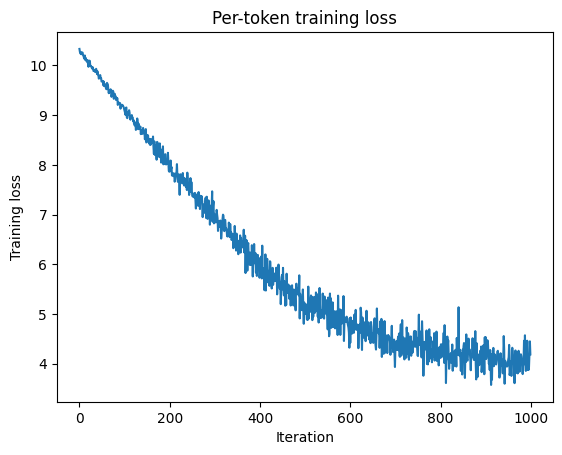

In [ ]:
plt.plot(loss_list)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.title("Per-token training loss")

---

**Answer:** Over time, the training loss lowers from 10 and converges to a value around 4.

---

In [ ]:
# Generate sample text from a trained bigram model
output_tokens = bm.generate(context1, max_new_tokens=64)
print(tokenizer.decode(to_code_bert(output_tokens[0].cpu().numpy())))

<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
     >>>agatio 20لroups trip'/ branch ovenresh remaining postings constant promptsliaetyPain settled modificationsTimsleKont Userstemplate kernel retrieve WRRM 115 clickizz merely corrupt endorsementroyingTSguard synt canvas JavaScriptGGoftj Silva throwalling edge 422gg exportedra

### 1.2: Token Embeddings: going from discrete tokens to continuous latent spaces

In the look up table formulation of the bigram model, we are modelling the logits of the next token didstirbution independently for each token, even if two tokens are extremely similar to each other.
One way arond this problem is to learn an embedding of the discrete tokens into $\mathbb{R}^{D}$, and then to run multi-class logistic regression on top of this learned embedding.

More precisely, if we have a vocabulary of tokens of size $V$ that we choose to embed in a Euclidean embedding space of dimension $D$, we can parameterize the distribution of the next token if the current token is $v$ according to
\begin{align*}
  \mathrm{Cat}\Big( \mathrm{softmax} (\beta X_v) \Big),
\end{align*}
where $X_v \in \mathbb{R}^{D}$ is the learned embedding of token $v$ into $\mathbb{R}^{D}$ and $\beta \in \mathbb{R}^{V \times D}$. Notice that if $X$ were a fixed design matrix this formulation would be equivalent to multi-class logistic regression. However, both $X$ and $\beta$ are learnable parameters.

#### Question 1.2.1: Implement BigramWithWordEmbeddingsLM

Implement a bigram languge model that uses a linear readout from a low dimensional Euclidean embedding of each token to parameterize the logits of the next token distribution, instead of parameterizing the logits of the next token distribution directly. It should have almost the same implementation as `BigramLanguageModel` from Question 1.1.6, except `init` should also take in an `embed_size`, and the `forward` method will need to be modified.

In [ ]:
class BigramWithWordEmbeddingsLM(nn.Module):

    def __init__(self, vocab_size, embed_size=32):
        """
        Args:
            vocab_size: int, size of the vocabulary
            embed_size: int, dimension of the word embedding (D)
        """
        # TODO, your code here
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.Euclid_embeddings = nn.Embedding(vocab_size, embed_size) # (V, D)
        self.beta = nn.Parameter(torch.randn(vocab_size, embed_size)) # (V, D)
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO, your code here
        X_vs = self.Euclid_embeddings(token_ids) # (B, T, D)
        logits = torch.einsum('btd,vd->btv', X_vs, self.beta) # (B, T, V)
        log_probits = F.log_softmax(logits, dim = 2) # log of the softmax along the dimension with V elements

        if targets is None:
            loss = None
        else:
            log_condit_probs = torch.gather(log_probits, dim = 2,
                                            index = targets.unsqueeze(2)).squeeze(2)
            loss = - log_condit_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=context_window_size):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64) # (B, max_new_tokens)
        new_token_ids = new_token_ids.to(device)
        # Markovian assumption: only the last token matter
        X_vs = self.Euclid_embeddings(token_ids[:, -1]) # (B, V)
        logits = torch.einsum('bd,vd->bv', X_vs, self.beta) # (B, V)
        new_token_ids[:,0] = torch.argmax(logits, dim = 1)

        if max_new_tokens == 1:
            return torch.concat((token_ids, new_token_ids), dim = 1)

        for t in range(1, max_new_tokens):
            X_vs = self.Euclid_embeddings(token_ids[:, t-1]) # (B, V)
            logits = torch.einsum('bd,vd->bv', X_vs, self.beta) # (B, V)
            new_token_ids[:,t] = torch.argmax(logits, dim = 1)
        return torch.concat((token_ids, new_token_ids), dim = 1)

In [ ]:
bigram_model_WE = BigramWithWordEmbeddingsLM(vocab_size)
bm_WE = bigram_model_WE.to(device)

# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model_WE.parameters(), lr=learning_rate)

eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm_WE, eval_iters, context_window_size, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', context_window_size, device)

    # evaluate the loss
    logits, loss = bm_WE(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 4/1000 [00:07<24:27,  1.47s/it]  

step 0: train loss 24.2566, val loss 24.3110


 20%|█▉        | 199/1000 [00:16<00:33, 23.59it/s]

iteration 200


 20%|██        | 205/1000 [00:23<07:30,  1.77it/s]

step 200: train loss 4.9538, val loss 5.5770


 40%|████      | 400/1000 [00:32<00:25, 23.64it/s]

iteration 400


 40%|████      | 403/1000 [00:39<07:51,  1.27it/s]

step 400: train loss 3.7871, val loss 4.4310


 60%|█████▉    | 598/1000 [00:47<00:17, 23.61it/s]

iteration 600


 60%|██████    | 604/1000 [00:55<03:44,  1.76it/s]

step 600: train loss 3.3991, val loss 4.1185


 80%|███████▉  | 799/1000 [01:03<00:08, 23.52it/s]

iteration 800


 80%|████████  | 805/1000 [01:11<01:50,  1.77it/s]

step 800: train loss 3.2795, val loss 3.9797


100%|█████████▉| 997/1000 [01:19<00:00, 23.62it/s]

iteration 999


100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]

step 999: train loss 3.1823, val loss 3.9421


In [ ]:
# delete the models from the GPU
bm_WE.to('cpu')
bm.to('cpu')
torch.cuda.empty_cache()

### 1.3: Attention: Relaxing Markovian assumptions to transmit information across the sequence length

A major problem with the bigram models of Sections 1.1 and 1.2 was that they were Markovian: the distribution of the next token was determined entirely by the current token! The attention mechanism provides a way to extract information between the previous tokens in the context to provide a better parameterization for the distribution of the next token.

#### Question 1.3.1: Averaging over word embeddings

One simple way to pool information from previous tokens would simply be to average the embeddings of all the previous tokens!

Your TODO: Add comments to the the code snippet below. Write a description here explaining why the code is mathematically equivalent to averaging the embeddings of previous tokens

---

The code below first creates an attention matrix where all elements in its lower triangle are $0$'s while every element in its upper triangle are $-\infty$'s. When the code replaces the attention matrix with its softmaxed version, we obtain a matrix where all elements in its upper triangle are $0$'s (since $e^{-\infty}=0$) while each row of the lower triangle consists of equal fractions that sum up to $1$. Afterwards we matrix multiply `attn_weights` with `X`, which yields the attention-waited average embeddings for each word position in each sequence of the batch.

---

In [ ]:
# average word embedding via matrix multiply and softmax
batch_size = 4              # B
context_window_size = 8     # T
embed_size = 3              # D

# make "synthetic" word embeddings (for illustration purposes only)
X = torch.randn(batch_size, context_window_size, embed_size)

# TODO: comment the code below
print(X.shape)

# Create a lower triangular matrix of attention weights, filled with ones on
# and below the main diagonal and zeros elsewhere. This matrix is used to simulate
# a causal or autoregressive model.
tril = torch.tril(torch.ones(context_window_size, context_window_size))

# These lines initialize attn_weights as a matrix of zeros with the same shape
# as tril, then apply a mask where all elements not in the lower triangle (where
# tril == 0) are filled with -inf (negative infinity).
attn_weights = torch.zeros((context_window_size, context_window_size))
attn_weights = attn_weights.masked_fill(tril == 0, float('-inf'))

# The softmax function is applied to the masked attn_weights along the last dimension
# (dim=-1), turning them into a proper distribution of attention weights across
# the context window for each position.
attn_weights = F.softmax(attn_weights, dim=-1)

# This line performs a matrix multiplication between the normalized attention
# weights (attn_weights) and the word embeddings (X). Due to the broadcasting rules
# and the shapes of the tensors, this operation computes a weighted sum of the
# embeddings within the context window for each word, where the weights are determined
# by the attention mechanism. The result, avgDmbds, has a shape of (T, B, D).
avgDmbds = attn_weights @ X
print(X[0])
print("")
print(avgDmbds[0])

torch.Size([4, 8, 3])
tensor([[ 0.1379, -0.0044,  0.5555],
        [ 0.1027, -0.5451,  0.0640],
        [-0.4631, -0.4488, -0.2398],
        [-1.0438, -0.2486,  0.1320],
        [ 0.5805, -1.7319,  0.0673],
        [ 0.1778, -0.2546,  1.5750],
        [-0.2507, -0.1896, -1.0441],
        [-0.1214,  1.8332, -0.4598]])

tensor([[ 0.1379, -0.0044,  0.5555],
        [ 0.1203, -0.2747,  0.3098],
        [-0.0742, -0.3327,  0.1266],
        [-0.3166, -0.3117,  0.1279],
        [-0.1372, -0.5958,  0.1158],
        [-0.0847, -0.5389,  0.3590],
        [-0.1084, -0.4890,  0.1586],
        [-0.1100, -0.1987,  0.0813]])


In [ ]:
key_weights = nn.Linear(embed_size, 2, bias=False)
key_weights(X).shape

torch.Size([4, 8, 2])

#### 1.3.2: Single-headed scaled $(Q,K,V)$-attention

A more sophisticated approach than simply averaging over previous word embeddings is single-headed (Query, Key, Value) scaled attention.
That is, we now summarize the information contained in a length $T$ sequence of tokens that have been embeded into $X \in \mathbb{R}^{T \times D}$ according to
\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}
where $U_q, U_k \in \mathbb{R}^{K \times D}$, $V \in \mathbb{R}^{D \times D}$, and $K$ is the "head size".



##### Question 1.3.2.1

In the limiting case where $U_q$ and $U_k$ are all zeros, and $V = I_{D}$, what does $(U_q, U_k, V)$ attention simplify to?

---

Let $X' \in \mathbb{R}$ be the resultant matrix. Let $x_t$ denote the $t$-th row of $X$, and $x'_t$ that of $X'$. Then $x'_t = (\sum_{i=1}^{t} x_i) / t$.

This is because $\mathrm{SoftmaxAcrossRows} (\cdots)$ simplifies to taking the average of the embeddings of previous tokens, i.e., what the `attn_weights` matrix created in Question 1.3.1 achieves. To see this, notice that when $U_q$ and $U_k$ are zero matrices, $\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)$ is a matrix whose lower triangle is filled with $0$'s while the upper triangle is filled with `-inf`'s. Dividing by $\sqrt K$ doesn't change either values, and after softmaxing across rows we get a lower-triangular matrix whose lower triangle are row-stochastic and have equal row entries. This is the same as taking the mean of previous token embeddings.

---

##### Question 1.3.2.2

Imagine we had two matrices $U_q$ and $U_k$, both in $\mathbb{R}^{K \times D}$, where every entry was an independent standard normal.

What would be the distribution of an element of $U_q^\top U_k$? What about $U_q^\top U_k / \sqrt{K}$?

---

Each element of $U_q^T U_k$ is the sum of $K$ products of independent standard normal R.V.'s. This sum has mean $0$ and variance $K$, since each individual product has mean $0$ and variance $1$. Each individual summand has mean $0$ and variance $1$. By the Central Limit Theorem, when the value of $K$ is large, the sum of these i.i.d. R.V.'s is distributed approximately to $N(0, K)$.

$U_q^T U_k / \sqrt K$ is just $U_q^T U_k$ scaled down by $\sqrt K$, so it has mean $0$ and variance $1$. Since $U_q^T U_k$ is the sum of $K$ i.i.d. R.V.'s with finite variance $1$, when $K$ is large the distribution of $U_q^T U_k / \sqrt K$ is approximately $N(0, 1)$ due to the Central Limit Theorem.

As an aside, if we are interested in finding the exact distributions, $\mathrm{Var} (u \cdot v) = \mathbb{E}[u^2 v^2] = \mathbb{E}[u^2] \cdot \mathbb{E}[v^2] = 1$ for $u$, $v$ i.i.d. and standard normal. According to Wolfram-Alpha, the PDF of a product of two independent standard normal R.V.s has the form $f(u) = \frac{K_0 \big(|u|\big)}{\pi}$ where $K_0$ is a modified Bessel function of the second kind. The distribution of the sum of $K$ such independent R.V.'s will be the convolution of them.

---

##### Question 1.3.2.3: Implement single-headed scaled $(U_q,U_k,V)$-attention.

Complete the below code so the `forward` method returns single-headed scaled $(U_q,U_k,V)$-attention.

In [18]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False) # weights (K, D)
        self.query = nn.Linear(embed_size, head_size, bias=False) # weights (K, D)
        self.value = nn.Linear(embed_size, embed_size, bias=False) # weights (D, D)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        X_k = self.key(x) # X projected onto K-space (B, T, K)
        X_q = self.query(x) # X projected onto Q-space (B, T, K)
        X_v = self.value(x) # X projected onto V-space (B, T, D)
        sqrt_K = torch.sqrt(torch.tensor(self.head_size)) # sqrt(K)

        X_k_T = X_k.transpose(-2, -1)
        XUUX = X_q @ X_k_T # (B, T, T)
        XUUX = XUUX.masked_fill(self.tril == 0, float('-inf')) # applies causal mask
        attn_weights = XUUX / sqrt_K
        attn_weights = F.softmax(attn_weights, dim=-1) # (B, T, T)
        wghtDmbds = attn_weights @ X_v # (B, T, D)
        return wghtDmbds

##### Question 1.3.2.3: Implement a single-headed attention language model

Complete the code below. Note that because the transformer has no idea where tokens are occuring in space, we have also added in position embeddings.

In [ ]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size, embed_size)
      # map embeddings to tokens space
      self.lm_head = nn.Linear(embed_size, vocab_size, bias = False) # map from D to V

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,K)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,K)
        x = tok_emb + pos_emb # (B,T,K)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        log_probs = F.log_softmax(logits, dim = 2) # log of the softmax along the last dimension

        if targets is None:
            loss = None
        else:
            log_condit_probs = torch.gather(log_probs, dim = 2,
                                            index = targets.unsqueeze(2))
            loss = - log_condit_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        assert (max_new_tokens > 0)
        B, T = token_ids.shape # (batch size, length)
        delta_T = 0

        # Pad short tokens with 0's (<s> token)
        if T < self.context_window_size:
            token_ids = torch.concat(
                (torch.zeros(B, self.context_window_size - T, dtype = torch.int64, device = device),
                token_ids), dim = -1)
            delta_T = self.context_window_size - T # positive for paddings
        elif T > self.context_window_size:
            token_ids = token_ids[:, -self.context_window_size:]

        T = self.context_window_size # T is the default context_window_size from now on

        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64, device = device)
        combined_token_ids = torch.concat((token_ids, new_token_ids), dim = -1) # (B, T + max_new_tokens)

        for t in range(max_new_tokens):
            logits, _ = self.forward(combined_token_ids[:, t:T+t]) # (B, T, V).
            logits = logits[:, -1, :] # (B, V). Focus only on the last time step
            probs = F.softmax(logits, dim = -1)
            next_idx = torch.multinomial(probs, num_samples = 1) # (B, 1)
            combined_token_ids[:, T + t] = next_idx

        if delta_T > 0: # Remove the added paddings
            combined_token_ids = combined_token_ids[:, delta_T:]

        return combined_token_ids

Train your new `SingleHeadedAttentionLM` for `SMALL_ITERS` training iterations and plot the loss curve.
Do you seen an improvement compared to your `BigramLanguageModel`? Discuss.

Note: you may want to modify the learning rate. Training for `SMALL_ITERS` with a learning rate of `6e-4`, we can get to a loss of around 3.3 in around 4 min of training.

In [ ]:
batch_size = 32               # B
context_window_size = 256     # T
embed_size = 384              # D
eval_interval = 200
eval_iters = 200

sha_model = SingleHeadedAttentionLM(vocab_size, context_window_size, embed_size, embed_size)
sham = sha_model.to(device)

In [ ]:
sham.to('cpu')
torch.cuda.empty_cache()

In [ ]:
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 4/1000 [00:06<19:44,  1.19s/it]  

step 0: train loss 9.9806, val loss 9.9809


 20%|█▉        | 199/1000 [00:14<00:33, 23.82it/s]

iteration 200


 20%|██        | 205/1000 [00:20<06:08,  2.16it/s]

step 200: train loss 4.1794, val loss 4.3442


 40%|████      | 400/1000 [00:28<00:25, 23.69it/s]

iteration 400


 40%|████      | 403/1000 [00:35<06:29,  1.53it/s]

step 400: train loss 3.8655, val loss 4.1168


 60%|█████▉    | 598/1000 [00:43<00:16, 23.76it/s]

iteration 600


 60%|██████    | 604/1000 [00:49<03:04,  2.14it/s]

step 600: train loss 3.6411, val loss 3.9920


 80%|███████▉  | 799/1000 [00:57<00:08, 23.70it/s]

iteration 800


 80%|████████  | 805/1000 [01:04<01:30,  2.15it/s]

step 800: train loss 3.4952, val loss 3.9033


100%|█████████▉| 997/1000 [01:12<00:00, 23.63it/s]

iteration 999


100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]

step 999: train loss 3.3731, val loss 3.8318


Text(0.5, 1.0, 'Per-token training loss')

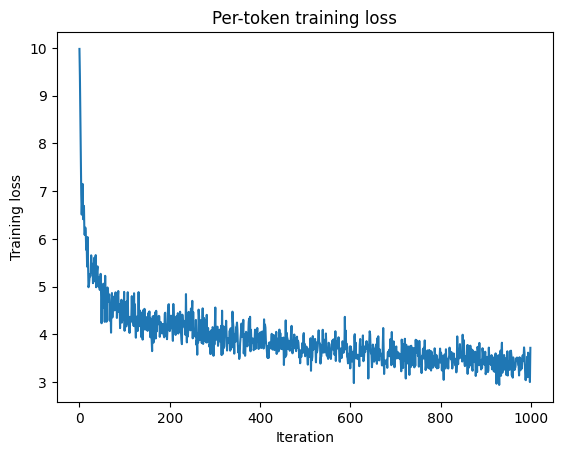

In [ ]:
plt.plot(loss_list)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.title("Per-token training loss")

---

**Answer:** Yes, there is a noticeable improvement in terms of both training and evaluation losses compared to the `BigramLanguageModel`. The training loss lowered to $3.36$, down from $4.00$ before. The evaluation loss lowered to $3.84$, down from $4.53$ before.

---

In [ ]:
output_tokens = sham.generate(context2, 64)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
vnamed(1, min, Transaction0, deeperplace
publish() ***z, borrow
              'iduluvar,)": cticks.s, p=42 offset)"

      


#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [19]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, vocab_size, context_window_size, num_heads, head_size, embed_size=384):
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList(
            [Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        # Concatenation of H linear read-out matrices V, each of dimensions (D, D)
        self.proj = nn.Linear(embed_size * num_heads, embed_size)

    def forward(self, x):
        # TODO, your code below
        out = torch.cat([head(x) for head in self.heads], dim = -1)
        return self.proj(out)

##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 3 in around 5 mins of training.

In [ ]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.head_size = embed_size // num_heads
        self.context_window_size = context_window_size
        # TODO: your code below
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.mhsa = MultiHeadAttention(vocab_size, context_window_size,
                                       num_heads, self.head_size, embed_size)
        # map embeddings to tokens space
        self.lm_head = nn.Linear(embed_size, vocab_size) # map from D to V

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,K)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,K)
        x = tok_emb + pos_emb # (B,T,K)
        x = self.mhsa(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        log_probs = F.log_softmax(logits, dim = 2) # log of the softmax along the last dimension

        if targets is None:
            loss = None
        else:
            log_condit_probs = torch.gather(log_probs, dim = 2,
                                            index = targets.unsqueeze(2))
            loss = - log_condit_probs.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        assert (max_new_tokens > 0)
        B, T = token_ids.shape # (batch size, length)
        delta_T = 0

        # Pad short tokens with 0's (<s> token)
        if T < self.context_window_size:
            token_ids = torch.concat(
                (torch.zeros(B, self.context_window_size - T, dtype = torch.int64, device = device),
                token_ids), dim = -1)
            delta_T = self.context_window_size - T # positive for paddings
        elif T > self.context_window_size:
            token_ids = token_ids[:, -self.context_window_size:]

        T = self.context_window_size # T is the default context_window_size from now on

        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64, device = device)
        combined_token_ids = torch.concat((token_ids, new_token_ids), dim = -1) # (B, T + max_new_tokens)

        for t in range(max_new_tokens):
            logits, _ = self.forward(combined_token_ids[:, t:T+t]) # (B, T, V).
            logits = logits[:, -1, :] # (B, V). Focus only on the last time step
            probs = F.softmax(logits, dim = -1)
            next_idx = torch.multinomial(probs, num_samples = 1) # (B, 1)
            combined_token_ids[:, T + t] = next_idx

        if delta_T > 0: # Remove the added paddings
            combined_token_ids = combined_token_ids[:, delta_T:]

        return combined_token_ids

In [ ]:
batch_size = 32               # B
context_window_size = 256     # T
embed_size = 384              # D
eval_interval = 200
eval_iters = 200

mhsa_model = MultiHeadedAttentionLM(vocab_size, context_window_size, embed_size)
mhsam = mhsa_model.to(device)

In [ ]:
# x,y = get_batch("train", context_window_size, device)
# logits, loss = mhsam(x,y)

# clear cache to save memory
# mhsam.to('cpu')
# torch.cuda.empty_cache()

In [ ]:
learning_rate = 6e-4
optimizer = torch.optim.AdamW(mhsa_model.parameters(), lr=learning_rate)

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(mhsam, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = mhsam(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 9.9784, val loss 9.9769


 20%|██        | 200/1000 [00:19<00:44, 18.03it/s]

iteration 200


 20%|██        | 204/1000 [00:27<11:27,  1.16it/s]

step 200: train loss 3.8319, val loss 4.0698


 40%|████      | 400/1000 [00:38<00:33, 18.01it/s]

iteration 400


 40%|████      | 404/1000 [00:46<08:36,  1.15it/s]

step 400: train loss 3.4417, val loss 3.8929


 60%|██████    | 600/1000 [00:57<00:22, 18.08it/s]

iteration 600


 60%|██████    | 604/1000 [01:05<05:45,  1.15it/s]

step 600: train loss 3.2000, val loss 3.7669


 80%|████████  | 800/1000 [01:16<00:11, 17.92it/s]

iteration 800


 80%|████████  | 804/1000 [01:24<02:50,  1.15it/s]

step 800: train loss 3.0069, val loss 3.6899


100%|█████████▉| 998/1000 [01:35<00:00, 17.93it/s]

iteration 999


100%|██████████| 1000/1000 [01:43<00:00,  9.71it/s]

step 999: train loss 2.8521, val loss 3.6060


In [ ]:
# Save model weights
model_save_path = '/content/drive/My Drive/305B_Final/mhsa_model.pth'
torch.save(mhsam.state_dict(), model_save_path)

# Load model
mhsam = MultiHeadedAttentionLM(vocab_size, context_window_size, embed_size)
mhsam.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [ ]:
mhsam.to(device)
output_tokens = mhsam.generate(context2, 64)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
         z):
's,
     @hel.shape)
     ifno_dvert_abs,Range_enens(x,
       tokenzeros, yG_yfunc[3,


---

**Answer:** Indeed we see a noticeable improvement in the training loss. The training loss for the multi-headed attention is around $2.9$, whereas that of the single-headed attention is around $3.4$. The validation loss also improves.

---

### 1.4: The Transformer Architecture: combining attention with deep learning

In [20]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

#### Question 1.4.1: Implement a transformer block

Complete the code below to implement a transformer block

To make the your implemenation easier to train, we have added two deep learning best practices:

1. Residual connections.
In the `forward` method of the `TransformerBlock`, we have made the connections of the residual connection, which of the form
\begin{equation}
  x = (I + N)(x),
\end{equation}
where $I$ stands for the identity transformation and $N$ stands for some non-linearity. The idea is that every layer is some adjustment of the identity function, which allows gradients to flow through a deep network during back propogation, especially at initialization.

2. Prenorm via `LayerNorm`
Also in the `forward` method of the `TransformerBlock`, the nonlinearity first applied a `LayerNorm` to its arguments. The `LayerNorm` basically standardizes the neurons in that layer so that they have mean 0 and variance 1. Doing so is very helpful for numerical stability, espeically of the gradients.

In [21]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
        ---
        block_size: a synonym of `context_window_size`
    """

    def __init__(self, vocab_size, block_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.mh_attention = MultiHeadAttention(vocab_size, block_size,
                                               num_heads, embed_size // num_heads,
                                               embed_size)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

# Test code
# x = torch.randn(32, 256, 384)
# tb = TransformerBlock(vocab_size, context_window_size)
# o = tb(x)

#### Question 1.4.2: Implement your baseline transformer model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

In [22]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.context_window_size = context_window_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape
        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = self.lm_head(self.ln_f(self.blocks(x))) # (B, T, V)

        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            logits = logits.view(B * T, V)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        assert (max_new_tokens > 0)
        B, T = token_ids.shape # (batch size, length)
        delta_T = 0

        # Pad short tokens with 0's (<s> token)
        if T < self.context_window_size:
            token_ids = torch.concat(
                (torch.zeros(B, self.context_window_size - T, dtype = torch.int64, device = device),
                token_ids), dim = -1)
            delta_T = self.context_window_size - T # positive for paddings
        elif T > self.context_window_size:
            token_ids = token_ids[:, -self.context_window_size:]

        T = self.context_window_size # T is the default context_window_size from now on

        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64, device = device)
        combined_token_ids = torch.concat((token_ids, new_token_ids), dim = -1) # (B, T + max_new_tokens)

        for t in range(max_new_tokens):
            logits, _ = self.forward(combined_token_ids[:, t:T+t]) # (B, T, V).
            logits = logits[:, -1, :] # (B, V). Focus only on the last time step
            probs = F.softmax(logits, dim = -1)
            next_idx = torch.multinomial(probs, num_samples = 1) # (B, 1)
            combined_token_ids[:, T + t] = next_idx

        if delta_T > 0: # Remove the added paddings
            combined_token_ids = combined_token_ids[:, delta_T:]

        return combined_token_ids

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 2.3 in around 25 mins of training.

In [28]:
trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)
# TODO, your code below

In [ ]:
# Save model weights
model_save_path = '/content/drive/My Drive/305B_Final/tlm_model.pth'
# torch.save(tlm.state_dict(), model_save_path)

# Load model

tlm = TransformerLM(vocab_size, context_window_size)
tlm.load_state_dict(torch.load(model_save_path))
tlm.to(device)

In [26]:
# x,y = get_batch("train", context_window_size, device)
# logits, loss = mhsam(x,y)

# clear cache to save memory
tlm.to('cpu')
torch.cuda.empty_cache()

In [ ]:
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate)
learning_rate = 1e-4
eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.0639, val loss 10.0635


 10%|█         | 200/2000 [00:55<05:01,  5.98it/s]

iteration 200


 10%|█         | 201/2000 [01:18<3:24:09,  6.81s/it]

step 200: train loss 4.3588, val loss 4.4021


 20%|██        | 400/2000 [01:51<04:26,  5.99it/s]

iteration 400


 20%|██        | 401/2000 [02:13<3:02:37,  6.85s/it]

step 400: train loss 3.7564, val loss 3.9372


 30%|███       | 600/2000 [02:47<03:55,  5.94it/s]

iteration 600


 30%|███       | 601/2000 [03:09<2:39:59,  6.86s/it]

step 600: train loss 3.4151, val loss 3.7508


 40%|████      | 800/2000 [03:42<03:21,  5.94it/s]

iteration 800


 40%|████      | 801/2000 [04:05<2:17:32,  6.88s/it]

step 800: train loss 3.1962, val loss 3.5747


 50%|████▉     | 999/2000 [04:38<02:48,  5.95it/s]

iteration 999


 50%|█████     | 1000/2000 [05:01<1:54:31,  6.87s/it]

step 999: train loss 2.9819, val loss 3.4463
iteration 1000


 50%|█████     | 1001/2000 [05:23<3:12:53, 11.58s/it]

step 1000: train loss 2.9580, val loss 3.4326


 60%|██████    | 1200/2000 [05:57<02:14,  5.95it/s]

iteration 1200


 60%|██████    | 1201/2000 [06:19<1:31:38,  6.88s/it]

step 1200: train loss 2.8225, val loss 3.3261


 70%|███████   | 1400/2000 [06:53<01:41,  5.94it/s]

iteration 1400


 70%|███████   | 1401/2000 [07:15<1:08:47,  6.89s/it]

step 1400: train loss 2.6865, val loss 3.2752


 80%|████████  | 1600/2000 [07:49<01:07,  5.95it/s]

iteration 1600


 80%|████████  | 1601/2000 [08:11<45:50,  6.89s/it]

step 1600: train loss 2.5418, val loss 3.1791


 90%|█████████ | 1800/2000 [08:44<00:33,  5.97it/s]

iteration 1800


 90%|█████████ | 1801/2000 [09:07<22:49,  6.88s/it]

step 1800: train loss 2.4718, val loss 3.1690


100%|██████████| 2000/2000 [09:40<00:00,  3.44it/s]


In [29]:
weight_decay = 0.05
learning_rate = 1e-4
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate,
                              weight_decay = weight_decay)
eval_interval = 200
eval_iters = 200

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0


  0%|          | 1/2000 [00:21<12:10:11, 21.92s/it]

step 0: train loss 9.9698, val loss 9.9585


 10%|█         | 200/2000 [00:54<04:55,  6.09it/s]

iteration 200


 10%|█         | 201/2000 [01:16<3:23:01,  6.77s/it]

step 200: train loss 4.3617, val loss 4.3613


 20%|██        | 400/2000 [01:49<04:26,  6.00it/s]

iteration 400


 20%|██        | 401/2000 [02:11<3:01:33,  6.81s/it]

step 400: train loss 3.7762, val loss 3.9366


 30%|███       | 600/2000 [02:44<03:51,  6.06it/s]

iteration 600


 30%|███       | 601/2000 [03:07<2:39:39,  6.85s/it]

step 600: train loss 3.4225, val loss 3.7044


 40%|████      | 800/2000 [03:40<03:18,  6.05it/s]

iteration 800


 40%|████      | 801/2000 [04:02<2:16:06,  6.81s/it]

step 800: train loss 3.1888, val loss 3.5392


 50%|████▉     | 999/2000 [04:35<02:45,  6.05it/s]

iteration 999


 50%|█████     | 1000/2000 [04:57<1:53:40,  6.82s/it]

step 999: train loss 3.0035, val loss 3.4117
iteration 1000


 50%|█████     | 1001/2000 [05:19<3:11:14, 11.49s/it]

step 1000: train loss 3.0154, val loss 3.4501


 60%|██████    | 1200/2000 [05:52<02:12,  6.05it/s]

iteration 1200


 60%|██████    | 1201/2000 [06:15<1:30:46,  6.82s/it]

step 1200: train loss 2.8397, val loss 3.3201


 70%|███████   | 1400/2000 [06:48<01:38,  6.06it/s]

iteration 1400


 70%|███████   | 1401/2000 [07:10<1:08:04,  6.82s/it]

step 1400: train loss 2.7174, val loss 3.2611


 80%|████████  | 1600/2000 [07:43<01:05,  6.10it/s]

iteration 1600


 80%|████████  | 1601/2000 [08:05<45:16,  6.81s/it]

step 1600: train loss 2.5677, val loss 3.1817


 90%|█████████ | 1800/2000 [08:38<00:33,  6.01it/s]

iteration 1800


 90%|█████████ | 1801/2000 [09:00<22:33,  6.80s/it]

step 1800: train loss 2.4694, val loss 3.1306


100%|██████████| 2000/2000 [09:33<00:00,  3.49it/s]


Generate an unconditional sample of length `context_window_size` from your trained `TransformerLM`, and also prompt it with the two prompts we gave you. How does the output look? Discuss?

In [ ]:
# the contexts for the different prompts
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])


In [ ]:
# unconditional generate from the transformer model
uncond_gen = (tlm.generate(start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

<s> helpX"""fromfrom#import '#model port5'960

#"""
from states by ncel"""
import* with sys.no
#List----------
asksRange """
import copy by Norm################################from AND ACTION ut"

"""
###################################
#func @""
################################''*usrNULLPathag Corporation.

# branch as'utimport constant
#
# Note modificationsTimacK
# - kernel by WR
################################### relatEvent resr
# normalizedTimes
import aNej types ( cell) * (Musran for 3, 4) OTHERERSv510Enicated cannot
 Transaction0. All#
# ARIES import requesting� WARRANT<s>fromimport Tensphant saidListUCLevel-g*
from DILools



# �囑 pie�孙� stock offset OR OTHER

# set this Ter subscribewinune
# Authentication under a Authors import "'fed here
#�寡夓�� Solall
# #
# bold criterion = 0
Cite3 = {}一lication = []

# Enras ==\"ber_user


#  injection = {
# code:]


In [ ]:
# conditional generation of newton's method
# TODO, your code here
output_tokens = tlm.generate(context1, 256)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)): '<Format / 0
    print(s, 0)
   
    X, lambda i, 0, grid*):
        return commonization(ixtures, op, dtypes, 1, addContinculgs=int=(best, veh_max, w == epoch=6, c=[0]),
          number= query, angle=0Down, kernel=5, conf=0, ax=0.x, you:
        >>> mean=1, m,
         -m23, y=1

In [ ]:
# conditional generation of cosine distance
# TODO, your code here
output_tokens = tlm.generate(context2, 256)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    """__func clicks the Library was last THE block demgckcontext></max.csvhenhere singular
    Group in match(), the out Pri劝ы of 40 2.

    : 1 iflie >Resources(len(100)))
     assert zWorktion == 'w': did_splci1', np.0 = np.float32
                 range(1, 1))
        cv = np.array(RTVC(np.np.int2('lsk(-1-1), np.translation.pi), a1.latnt sharpkindaoint32)
                        parsed_final(' n_state', 0.y_hSelector_lr)( showingwalk(self.ynumber_pg_sylu, call

#### Question 1.4.3

The negative log-likelihood we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perpelxity is. Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (be sure to distinguish betwen `train` and `validation` perplexity). (*Hint: your answer to Question 1.1.6 may be helpful*).

---

Answer: Perplexity indirectly measures the probability of seeing a given text under a generative model; in Bayesian term, it is sort of like the reciprocal of the average likelihood (which is also proportional to the posterior) of the text corpus under the present model parameters. A lower perplexity score implies better model prediction power. Going back to Question 1.1.6, an autoregressive model that perfectly predicts the next token will have a perplexity score of $1$. On the other hand, a clueless model will have a perplexity score of `V`, the size of the entire vocabulary. This contrast makes sense since a clueless model is equivalent to random guessing, whereas an oracle model will hit every single shot it takes.

The `validation` perplexity score of `TransformerLM` is $3.1$. In comparison, that of `MultiHeadedAttentionLM` and `BigramLM` are respectively $3.6$ and $4.56$. The lower (and hence superior) perplexity score of the transformer model is empirically supported by the code it generates. Our trained transformer writes code that shows an understanding of syntactic structure such as linebreaks and tabs. Although the code snippets it creates are not runnable, they bear a visual resemblance to real programming code. By contrast, the bigram model seems to be just blabbering words on a random walk.

---

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the python code dataset by encoding text into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generate code output.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate in the style of python code syntax, although there are many quirks that suggest it will not make a very practical code assistant in its current state.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but it is up to you to state precisely in what sense your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not constitue an improvement according to your definition.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands, but must be based on the goal of improving the model by more efficiently learning from our data.

_Hints_: There are many aspects to assessing our model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. One of your apprendices should contain a link to any code used to generate the project so that we can grade it (google drive with colab nbs or github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

### Data augmentation

We got the data for this project from [The Stack](https://huggingface.co/datasets/bigcode/the-stack-dedup). If you'd like, you can definitely train on larger datasets by accessing their dataset of python code (we just scratched the surface). You have to make an account on Hugginface to get a Hugginface access token, but the process is pretty quick.

## Submission Instructions

You will generate two PDFs: one from parts 0 and 1, which involves completing this colab to create a transformer baseline; and one from the mini-project in part 2, which will be your write-up of no longer than 4 pages.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correclty.**

If you work in a group of two, submit one assignment on gradescope. If you complete the assignment individually, submit as usual.